# Deep Learning-Based Sentiment Analysis for Telugu Text Using Pre-trained Word Embeddings and LSTM Models

# 1: Import Libraries

In [ ]:
# In[1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import gensim
import ipywidgets as widgets
from IPython.display import display


# 2. Load Text Data and Preprocess


In [ ]:
# In[2]:
def load_text_data(folder_path, label):
    texts = []
    labels = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(label)
    return texts, labels


# 3. Load Sentiraama Corpus Data

In [ ]:
# In[3]:
base_dir = "path_to_sentiraama_corpus"  # Update with the actual path to Sentiraama Corpus folders

# Load data from each folder
book_texts, book_labels = load_text_data(os.path.join(base_dir, "Book_Reviews"), label="neutral")
movie_texts, movie_labels = load_text_data(os.path.join(base_dir, "Movie_Reviews"), label="neutral")
product_texts, product_labels = load_text_data(os.path.join(base_dir, "Product_Reviews"), label="neutral")
song_neg_texts, song_neg_labels = load_text_data(os.path.join(base_dir, "Song_Lyrics/negative"), label="negative")
song_pos_texts, song_pos_labels = load_text_data(os.path.join(base_dir, "Song_Lyrics/positive"), label="positive")

# Combine all data
texts = book_texts + movie_texts + product_texts + song_neg_texts + song_pos_texts
labels = book_labels + movie_labels + product_labels + song_neg_labels + song_pos_labels

# Create a DataFrame for easy manipulation
data = pd.DataFrame({"text": texts, "sentiment": labels})

# Display dataset statistics
print("Dataset Loaded:")
print(data["sentiment"].value_counts())


Dataset Loaded:
positive    229
negative    108
neutral       6
Name: sentiment, dtype: int64


# 4. Data Preprocessing

In [ ]:
# In[4]:
def preprocess_telugu_text(text):
    if isinstance(text, str):  # Ensure text is a string
        text = text.lower()
    else:
        text = ""  # Replace non-string values with empty strings
    return text

# Apply preprocessing
data["cleaned_text"] = data["text"].apply(preprocess_telugu_text)

# Debugging: Confirm the 'cleaned_text' column is created
if "cleaned_text" in data.columns:
    print("Column 'cleaned_text' successfully created.")
    print(data[["text", "cleaned_text"]].head())
else:
    raise KeyError("Failed to create the 'cleaned_text' column. Check the preprocessing logic.")


Column 'cleaned_text' successfully created.
                                                text  \
0  __________________________\nఏదైనా చెప్పడానికి...   
1  __________________________\nనా జీవితంలో ఆడుజీవ...   
2           దయ్యం ఆవహించి తనపై అత్యాచారం చేయబోయిన...   
3  చిన్నప్పటి నుంచి గురుకులంలో చదువుకున్న అరవింద్...   
4  __________________________\nహలో ఫ్రెండ్స్ నేను...   

                                        cleaned_text  
0  __________________________\nఏదైనా చెప్పడానికి...  
1  __________________________\nనా జీవితంలో ఆడుజీవ...  
2           దయ్యం ఆవహించి తనపై అత్యాచారం చేయబోయిన...  
3  చిన్నప్పటి నుంచి గురుకులంలో చదువుకున్న అరవింద్...  
4  __________________________\nహలో ఫ్రెండ్స్ నేను...  


# 5. Tokenization and Padding

In [ ]:
# In[5]:
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100

# Tokenization
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(data["cleaned_text"])

# Convert text to sequences
X = tokenizer.texts_to_sequences(data["cleaned_text"])

# Pad sequences to ensure uniform length
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Map sentiments to numeric values
y = data["sentiment"].map({"positive": 1, "negative": 0, "neutral": 2}).values

# Split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Debugging: Confirm shapes of datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Shape of X_train: (274, 100)
Shape of X_test: (69, 100)
Shape of y_train: (274,)
Shape of y_test: (69,)


# 6. Load Pre-trained Word Embeddings

In [ ]:
import gensim
import numpy as np

def load_pretrained_embeddings(embedding_file, tokenizer, embedding_dim=300, binary=True):
    """Load pre-trained word embeddings and create embedding matrix."""

    # Load the word2vec model using the correct function
    word_vectors = gensim.models.KeyedVectors.load_word2vec_format(embedding_file, binary=binary)

    # Prepare the embedding matrix
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))  # +1 for zero padding
    for word, i in tokenizer.word_index.items():
        if word in word_vectors:
            embedding_matrix[i] = word_vectors[word]

    return embedding_matrix


# 7. Build the Model with Pre-trained Embeddings

In [ ]:
# Set the path for the text-based embedding file (wiki.te.vec)
embedding_file = "wiki/wiki.te.vec"  # Change to the correct path if necessary
embedding_dim = 300  # Typical word2vec embedding dimension

# Load the pre-trained word embeddings (binary=False for .vec files)
embedding_matrix = load_pretrained_embeddings(embedding_file, tokenizer, embedding_dim, binary=False)

# Build the model with pre-trained embeddings
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],  # Load pre-trained embeddings
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),  # Set to False to prevent fine-tuning the embeddings
    LSTM(128, return_sequences=True, dropout=0.2),
    LSTM(64, dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # Adjust output layer for three-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          14060400  
                                                                 
 lstm (LSTM)                 (None, 100, 128)          219648    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 14333811 (54.68 MB)
Trainable params: 2734

# 8. Train the Model

In [ ]:
# In[8]:
# Train the model without EarlyStopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,  # Increased epochs for fine-tuning
    batch_size=32,
    verbose=1
)

Epoch 1/15
7/7 [==============================] - 5s 246ms/step - loss: 0.9291 - accuracy: 0.6027 - val_loss: 0.7853 - val_accuracy: 0.6182
Epoch 2/15
7/7 [==============================] - 1s 128ms/step - loss: 0.7103 - accuracy: 0.6895 - val_loss: 0.7534 - val_accuracy: 0.6182
Epoch 3/15
7/7 [==============================] - 1s 124ms/step - loss: 0.6953 - accuracy: 0.6758 - val_loss: 0.7495 - val_accuracy: 0.6182
Epoch 4/15
7/7 [==============================] - 1s 122ms/step - loss: 0.6641 - accuracy: 0.7032 - val_loss: 0.7699 - val_accuracy: 0.6182
Epoch 5/15
7/7 [==============================] - 1s 125ms/step - loss: 0.6328 - accuracy: 0.6986 - val_loss: 0.7455 - val_accuracy: 0.6182
Epoch 6/15
7/7 [==============================] - 1s 133ms/step - loss: 0.5869 - accuracy: 0.7260 - val_loss: 0.8205 - val_accuracy: 0.4545
Epoch 7/15
7/7 [==============================] - 1s 134ms/step - loss: 0.5795 - accuracy: 0.7215 - val_loss: 0.8220 - val_accuracy: 0.6000
Epoch 8/15
7/7 [====

# 9. Evaluate the Model

In [ ]:
# In[9]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
y_pred = model.predict(X_test).argmax(axis=1)
print("Classification Report:\n", classification_report(y_test, y_pred))

3/3 [==============================] - 0s 31ms/step - loss: 0.7112 - accuracy: 0.6957
Test Accuracy: 69.57%
3/3 [==============================] - 1s 30ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.56      0.58        25
           1       0.73      0.79      0.76        42
           2       1.00      0.50      0.67         2

    accuracy                           0.70        69
   macro avg       0.78      0.62      0.67        69
weighted avg       0.70      0.70      0.69        69



# 10. Confusion Matrix Visualization

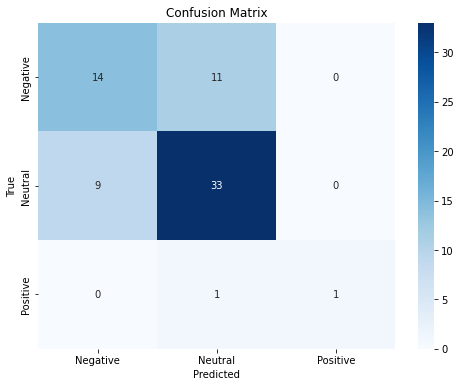

In [ ]:
# In[10]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 11. ROC Curve and AUC Visualization

3/3 [==============================] - 0s 31ms/step


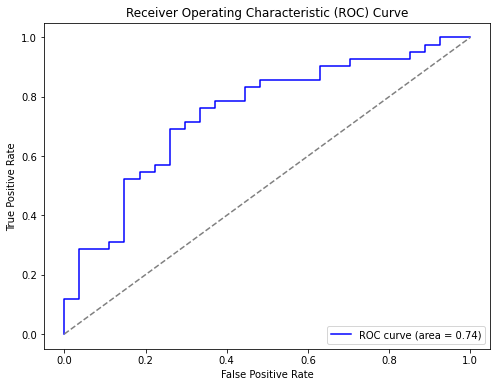

In [ ]:
# In[11]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test)[:,1], pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 12. Visualizing Training History

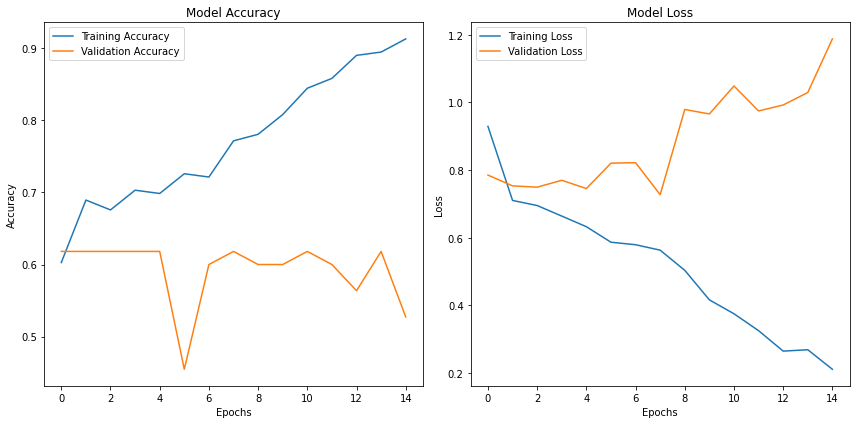

In [ ]:
# In[12]:
# Visualizing both accuracy and loss on the same graph
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 13. Save the Model

In [ ]:
# In[10]:
model.save('sentiraama_opinion_mining_model.h5')
print("Model saved as 'sentiraama_opinion_mining_model.h5'")


c:\users\ram\appdata\local\programs\python\python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as 'sentiraama_opinion_mining_model.h5'


# 14. Interactive Widget for Real-Time Prediction

In [ ]:
# In[14]:
def predict_sentiment(text):
    # Preprocess input text
    cleaned_text = preprocess_telugu_text(text)
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_SEQUENCE_LENGTH)

    # Predict sentiment
    prediction = model.predict(padded_sequence)
    sentiment = ['negative', 'positive', 'neutral']

    return sentiment[np.argmax(prediction)]

# Create input widget
text_input = widgets.Textarea(placeholder='Enter Telugu text for sentiment prediction...', layout=widgets.Layout(width='50%', height='100px'))
predict_button = widgets.Button(description="Predict Sentiment", button_style='success')
output = widgets.Output()

# Define button click behavior
def on_button_click(b):
    with output:
        result = predict_sentiment(text_input.value)
        print(f"Predicted Sentiment: {result}")

predict_button.on_click(on_button_click)

# Display widget
display(text_input, predict_button, output)


Textarea(value='', layout=Layout(height='100px', width='50%'), placeholder='Enter Telugu text for sentiment pr…

Button(button_style='success', description='Predict Sentiment', style=ButtonStyle())

Output()